In [24]:
#Importar librerias

import pandas as pd
import neurolab as nl
import seaborn as sns
import matplotlib.pyplot as plt

#Ajustar tamaño de graficas
plt.rcParams['figure.figsize'] = [10, 7]
#Desactivar Warnings de Referenciado en pandas
pd.options.mode.chained_assignment = None

In [25]:
#Load CSV Data

with open(r"Data\Proy_Final_data.csv") as file:
    Data = pd.read_csv(file, sep= ",")

#Eliminar columna indice
Data = Data.drop({"Unnamed: 0"}, axis="columns")

print("-------------------------------")
print("Data Cargada: ")
print(Data.head(4))
print("-------------------------------")
print("Informacion del Dataset: ")
print(Data.info())
print("-------------------------------")

-------------------------------
Data Cargada: 
   credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1         credit_card    0.1505       277.53       11.289782   
1              1  debt_consolidation    0.1253       133.87       10.596635   
2              1  debt_consolidation    0.1392       682.74       11.350407   
3              0           all_other    0.0768       405.48       10.736310   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  12.07   667        3509.041667       9229        93.2               1   
1  18.39   687        4050.000000       7227        70.9               0   
2  11.55   697        5220.000000      17250        78.3               2   
3  23.64   712        3240.000000      58996        55.7               3   

   delinq.2yrs  pub.rec  not.fully.paid  
0            0        0               0  
1            0        0               0  
2            1        0               0  
3       

In [26]:
#Codificacion de propositos

#Valores unicos de la columna de propositos
print("-------------------------------")
print("Valores unicos de la columna de propositos: ")
print(Data["purpose"].unique())
print("-------------------------------")

#Asignacion de valores numericos
Purposes = {
    "credit_card" : 0,
    "debt_consolidation" : 1,
    "educational" : 2,
    "major_purchase" : 3,
    "small_business" : 4,
    "all_other" : 5,
    "home_improvement" : 6
}

#Copia de dataset
CodedData = Data.copy()

#Asignacion de codigos a propositos
index = 0
for Purpose in Data["purpose"]:
    for UniquePurpose in Purposes:
        if UniquePurpose == Purpose:
            CodedData["purpose"][index] = Purposes[UniquePurpose] 
    index = index + 1

CodedData = CodedData.apply(pd.to_numeric)

#Dataset Codificado
print("-------------------------------")
print("Dataset Codificado: ")
print(CodedData.head())
print("-------------------------------")

-------------------------------
Valores unicos de la columna de propositos: 
['credit_card' 'debt_consolidation' 'all_other' 'major_purchase'
 'home_improvement' 'small_business' 'educational']
-------------------------------
-------------------------------
Dataset Codificado: 
   credit.policy  purpose  int.rate  installment  log.annual.inc    dti  fico  \
0              1        0    0.1505       277.53       11.289782  12.07   667   
1              1        1    0.1253       133.87       10.596635  18.39   687   
2              1        1    0.1392       682.74       11.350407  11.55   697   
3              0        5    0.0768       405.48       10.736310  23.64   712   
4              1        3    0.1537       174.24       10.463103  11.67   672   

   days.with.cr.line  revol.bal  revol.util  inq.last.6mths  delinq.2yrs  \
0        3509.041667       9229        93.2               1            0   
1        4050.000000       7227        70.9               0            0   
2     

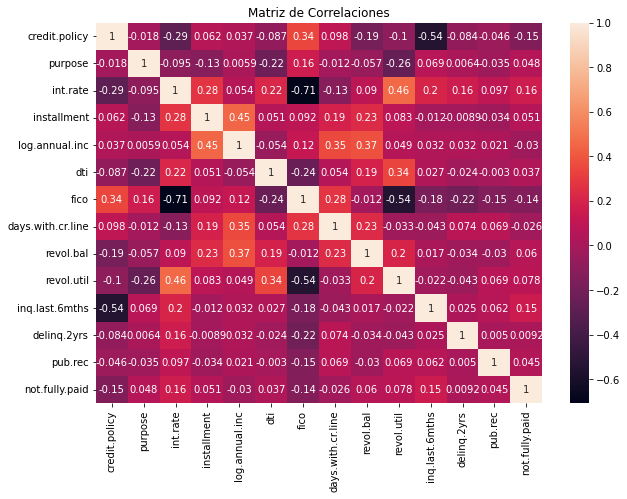

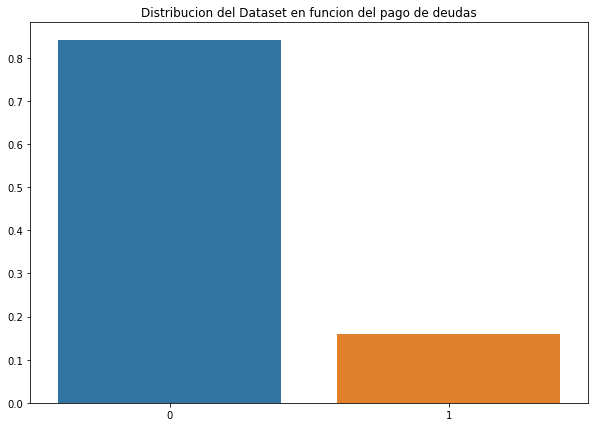

<Figure size 720x504 with 0 Axes>

In [27]:
#Estadisticos del Dataset

#Correlacion entre variables
Correlation = CodedData.corr()
sns.heatmap(Correlation, annot=True)
plt.title("Matriz de Correlaciones")
plt.figure(1)
plt.show()

#Grafico de dispersion
sns.barplot(x = (CodedData["not.fully.paid"].unique()), 
            y = CodedData.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')/CodedData.shape[0])
plt.title("Distribucion del Dataset en funcion del pago de deudas")
plt.figure(2)
plt.show()

In [45]:
#Metodologia de Dataset Completo

#Normalizar el Dataset
NormalizedData = (CodedData - CodedData.min()) / (CodedData.max() - CodedData.min())

#Red Neuronal
#Neuronas de entrada
NInput = [[0,1] for size in range(len(NormalizedData.columns) - 1)]

#Estructura Red Neuronal
Network = nl.net.newff(NInput,[26,52,1])

#Entradas de entrenamiento
TrainInputs = [[0 for size in range(len(NormalizedData.columns) - 1)] for size in range(NormalizedData.shape[0])]
for DtIndex in range(len(TrainInputs)):
    i = 0
    for Column in NormalizedData.columns:
        if (Column != "not.fully.paid"):
            (TrainInputs[DtIndex])[i] = NormalizedData[Column][DtIndex]
            i = i + 1

#Salidas de entrenamiento
TrainTarget = [[0] for size in range(NormalizedData.shape[0])]
for DtIndex in range(len(TrainTarget)):
    TrainTarget[DtIndex][0] = NormalizedData["not.fully.paid"][DtIndex]

NetworkError = Network.train(TrainInputs,TrainTarget, epochs = 400, goal = 0.5, show = 5)
Network.save(r"OutPut\ANN\Network_Dataset_Completo")

plt.plot(NetworkError)
plt.title("Error Proceso de Entrenamiento (DataSet Completo)")
plt.figure(3)
plt.show()


In [52]:
#Metodologia de Balanceo por submuestreo de la clase mayoritaria

NAproved = CodedData.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')[1]
NRejected = CodedData.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')[0]
NSubsamples = (NRejected/NAproved)
print("Cantidades de creditos aprobados")
print(NAproved)
print("Candidades de creditos rechazados")
print(NRejected)
print("Numero de submuestras")
print(NSubsamples)

RejectedDT = NormalizedData.loc[NormalizedData["not.fully.paid"] == 0].copy()
AProvedDT = NormalizedData.loc[NormalizedData["not.fully.paid"] == 1].copy()

Subsamples = list()
for i in range(int(NSubsamples)):
    Subsample = RejectedDT.sample(frac = 1/(NSubsamples - i), random_state = 200)
    RejectedDT = RejectedDT.drop(Subsample.index)
    Subsample = pd.concat([Subsample, AProvedDT])
    Subsamples.append(Subsample)

print("Submuestras: ")
for Subsample in Subsamples:
    print(Subsample.shape)


#Neuronas de entrada
NInput = [[0,1] for size in range(len(Subsample[0].columns) - 1)]

z = 0
for Subsample in Subsamples:

    #Entradas de entrenamiento
    TrainInputs = [[0 for size in range(len(Subsample.columns) - 1)] for size in range(Subsample.shape[0])]
    for DtIndex in range(len(TrainInputs)):
        i = 0
        for Column in Subsample.columns:
            if (Column != "not.fully.paid"):
                (TrainInputs[DtIndex])[i] = Subsample[Column][DtIndex]
                i = i + 1

    #Salidas de entrenamiento
    TrainTarget = [[0] for size in range(Subsample.shape[0])]
    for DtIndex in range(len(TrainTarget)):
        TrainTarget[DtIndex][0] = Subsample["not.fully.paid"][DtIndex]

    if z == 0:
        #Estructura Red Neuronal
        Network = nl.net.newff(NInput,[26,52,1])
        NetworkError = Network.train(TrainInputs,TrainTarget, epochs = 400, goal = 0.5, show = 5)
        Network.save(r"OutPut\ANN\Network_Subsample_equal")
    else:
        

    plt.plot(NetworkError)
    plt.title("Error Proceso de Entrenamiento (DataSet Sumbsampleado N°"+")")
    plt.figure(3)
    plt.show()


Cantidades de creditos aprobados
1303
Candidades de creditos rechazados
6838
Numero de submuestras
5.247889485801996
Submuestras: 
(2606, 14)
(2606, 14)
(2606, 14)
(2606, 14)
(2606, 14)
